# Part II: Cell-Cell Interaction Analysis

**Requirements:**
|  | Description |
|-----------|-------------|
| **Python library** | liana (v1.5.1), omnipath (v1.0.8) |
| **Database** | OmniPath database |
| **Input data** | Anndata object with whole cell type annotation + AnnData object of receiver cell type with sub-cell type annotation |

## [1] Import modules and set global environment

In [3]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
import cmap as cm
import scanpy as sc

import pulso
from natsort import natsorted
import squidpy as sq
from matplotlib_set_diagrams import EulerDiagram, VennDiagram
import networkx as nx
from itertools import product
import omnipath
import liana

In [4]:
work_dir = "/home/qbe2n/PULSO"

In [5]:
prev_file = "/home/qbe2n/04.PSO/3.T&ILC/ann.h5ad"
adata = sc.read(prev_file)

In [6]:
adata_all = sc.read("/home/qbe2n/04.PSO/2.all/ann.h5ad")
adata_all

AnnData object with n_obs × n_vars = 64912 × 27296
    obs: 'suffix', 'sample', 'donor', 'condition', 'origin', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'S_score', 'G2M_score', 'phase', 'leiden_all_raw', 'scrub_doublet_score', 'scrub_predicted_doublet', 'dd_doublet_score', 'dd_predicted_doublet', 'doublet', 'leiden_all', 'celltype_0', 'celltype_0_numbered'
    var: 'gene_ids', 'feature_types', 'genome', 'entrezgene', 'map_location', 'type_of_gene', 'mt', 'rb', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'means', 'variances', 'highly_variable_nbatches', 'highly_variable_rank', 'variances_norm', 'highly_variable'
    uns: 'leiden_all', 'leiden_all_raw', 'leiden_all_raw_colors', 'log1

## [2] Ligand Selection

In [ ]:
out_file = f"{work_dir}/lig_pred_pp.h5ad"
prev_file = f"{work_dir}/lig_pred.h5ad"

ldata = pulso.lig_pred_pp(adata, adata_all, prev_file, out_file)
print(ldata)

Creating /home/qbe2n/PULSO/lig_pred_pp.h5ad...


AnnData object with n_obs × n_vars = 14645 × 876
    obs: 'suffix', 'sample', 'donor', 'condition', 'origin', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'S_score', 'G2M_score', 'phase', 'leiden_all_raw', 'scrub_doublet_score', 'scrub_predicted_doublet', 'dd_doublet_score', 'dd_predicted_doublet', 'doublet', 'leiden_all', 'celltype_0', 'celltype_0_numbered', 'leiden_sub', 't17_score', 'trm_score', 'core_trm_score', 'celltype_1', 'celltype_1_numbered'


In [22]:
adata.obs["celltype_1"].cat.categories

Index(['CD4$^{+}$TRM-Rest', 'CD4$^{+}$TRM-Actv', 'CD4$^{+}$CTL', 'Treg',
       'CD8$^{+}$TRM-Rest', 'CD8$^{+}$TRM-Actv', 'CD8$^{+}$CTL-Rest',
       'CD8$^{+}$CTL-Actv', 'MAIT', 'TRecir', 'Stressed', 'Cycling', 'ILC/NK'],
      dtype='object')

In [23]:
celltypes_oi = ["CD4$^{+}$TRM-Actv", "CD8$^{+}$TRM-Actv"]
ref_celltypes = ["CD4$^{+}$TRM-Rest", "CD8$^{+}$TRM-Rest"]
lfc_thres = np.log2(1.25)
pct_thres = 0.2

In [24]:
lig_dt = pulso.run_ligand_differential_test(
    ldata,
    celltypes_oi=celltypes_oi,
    ref_celltypes=ref_celltypes,
    lfc_thres=lfc_thres,
    pct_thres=pct_thres,
)
all_ctps = list(lig_dt.keys())
lig_dt.keys()

class
ns    819
up     57
Name: PV:CD4$^{+}$TRM-Actv vs PV:CD4$^{+}$TRM-Rest, dtype: int64
class
ns    749
up    127
Name: PV:CD4$^{+}$TRM-Actv vs PV:CD8$^{+}$TRM-Rest, dtype: int64
class
ns    716
up    160
Name: PV:CD4$^{+}$TRM-Actv vs HC:CD4$^{+}$TRM-Rest, dtype: int64
class
ns    676
up    200
Name: PV:CD4$^{+}$TRM-Actv vs HC:CD8$^{+}$TRM-Rest, dtype: int64
class
ns      800
up       70
down      6
Name: PV:CD8$^{+}$TRM-Actv vs PV:CD4$^{+}$TRM-Rest, dtype: int64
class
ns    717
up    159
Name: PV:CD8$^{+}$TRM-Actv vs PV:CD8$^{+}$TRM-Rest, dtype: int64
class
ns    721
up    155
Name: PV:CD8$^{+}$TRM-Actv vs HC:CD4$^{+}$TRM-Rest, dtype: int64
class
ns    677
up    199
Name: PV:CD8$^{+}$TRM-Actv vs HC:CD8$^{+}$TRM-Rest, dtype: int64


dict_keys(['PV:CD4$^{+}$TRM-Actv vs PV:CD4$^{+}$TRM-Rest', 'PV:CD4$^{+}$TRM-Actv vs PV:CD8$^{+}$TRM-Rest', 'PV:CD4$^{+}$TRM-Actv vs HC:CD4$^{+}$TRM-Rest', 'PV:CD4$^{+}$TRM-Actv vs HC:CD8$^{+}$TRM-Rest', 'PV:CD8$^{+}$TRM-Actv vs PV:CD4$^{+}$TRM-Rest', 'PV:CD8$^{+}$TRM-Actv vs PV:CD8$^{+}$TRM-Rest', 'PV:CD8$^{+}$TRM-Actv vs HC:CD4$^{+}$TRM-Rest', 'PV:CD8$^{+}$TRM-Actv vs HC:CD8$^{+}$TRM-Rest'])

In [25]:
valid_comparisons = [
    k
    for k in lig_dt.keys()
    if (
        (k.split()[0][5] == k.split()[-1][5])
        and (k.split()[0].split(":")[0] == k.split()[-1].split(":")[0])
    )
]
for k in list(lig_dt.keys()):
    if k not in valid_comparisons:
        _ = lig_dt.pop(k)
lig_dt.keys()

dict_keys(['PV:CD4$^{+}$TRM-Actv vs PV:CD4$^{+}$TRM-Rest', 'PV:CD8$^{+}$TRM-Actv vs PV:CD8$^{+}$TRM-Rest'])

In [26]:
sig_ligs = pulso.get_differentially_acting_ligands(
    lig_dt, ldata=ldata, celltypes_oi=celltypes_oi, pct_thres=pct_thres, n_up_offset=0
)
sig_ligs

False    845
True      31
Name: count, dtype: int64


['ICOSLG',
 'HLA-DMA',
 'CLEC2B',
 'ITGB2',
 'CLEC2L',
 'MICA',
 'ULBP2',
 'RAET1E',
 'HLA-DMB',
 'CLEC2A',
 'ICAM4',
 'CCN1',
 'IL12A',
 'CD80',
 'HLA-E',
 'MICB',
 'COPA',
 'VTN',
 'ANGPTL4',
 'SPON2',
 'ADAM17',
 'ICAM3',
 'IL12B',
 'OGN',
 'F11R',
 'CLEC2D',
 'IL23A',
 'ICAM5',
 'CCN2',
 'ANGPTL2',
 'ICAM2']

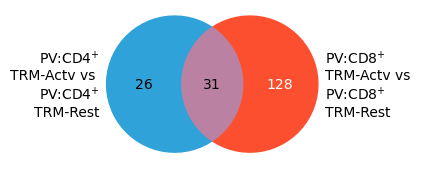

In [34]:
from textwrap import wrap

fig, ax = plt.subplots(figsize=(3, 2))
set_data = [set(lig_dt[k].index[lig_dt[k]["class"] == "up"]) for k in lig_dt.keys()]
VennDiagram.from_sets(
    set_data,
    set_labels=["\n".join(wrap(k, 12)) for k in lig_dt.keys()],
    ax=ax,
    set_colors=cc.glasbey_hv,
)

for text in ax.texts:
    x, y = text.get_position()
    text.set_position((x, 0))

In [28]:
ct_oi = []
for k in all_ctps:
    e = k.split()
    ct_oi.append(e[0])
    ct_oi.append(e[-1])
ct_oi = natsorted(set(ct_oi))
ct_oi = [x for x in ct_oi if x.split(":")[-1] in celltypes_oi]
ct_oi

['PV:CD4$^{+}$TRM-Actv', 'PV:CD8$^{+}$TRM-Actv']

## [3] Cell-Cell Interaction Analysis

In [36]:
adata_pv = adata_all[adata_all.obs["condition"] == "PV"].copy()
nz_genes = pd.Series(adata_pv.X.getnnz(axis=0).flatten(), index=adata_pv.var_names)
adata_pv = adata_pv[:, nz_genes.index[(nz_genes >= 10)]].copy()
print(adata_pv)

_adata_all = adata_pv
ligands_oi = sig_ligs
celltypes_oi = [x for x in ct_oi if str(x).split(":")[0] == "PV"]
celltype_coarse_oi = "T&ILC"
exp_frac_thres = 5e-2
celltype_key: str = "celltype_1"
celltype_coarse_key: str = "celltype_0"
condition_key: str = "condition"
key_added: str = "celltype_01c"
sep: str = ":"
group_thres: int = 50

lr_df = omnipath.interactions.import_intercell_network(
    transmitter_params={"categories": "ligand"},
    receiver_params={"categories": "receptor"},
)
_lr_df = lr_df[["genesymbol_intercell_source", "genesymbol_intercell_target"]]
_lr_df.columns = ["source", "target"]
_lr_df = _lr_df.loc[_lr_df["source"].isin(ligands_oi)]
_lr_df = _lr_df.loc[_lr_df["source"].isin(_adata_all.var_names)]
_lr_df = _lr_df.loc[_lr_df["target"].isin(adata.var_names)]
_lr_df = _lr_df.drop_duplicates().reset_index(drop=True)

annot = adata.obs[celltype_key]
_adata_all.obs[key_added] = (
    _adata_all.obs[condition_key].astype(str)
    + sep
    + _adata_all.obs.apply(
        lambda row: (annot.loc[row.name])
        if (row.name in annot.index)
        else (row[celltype_coarse_key]),
        axis=1,
    ).astype("str")
).astype("category")

val_cts = _adata_all.obs[key_added].value_counts() >= group_thres
adata_all_ = _adata_all[_adata_all.obs[key_added].isin(val_cts[val_cts].index)].copy()

sr_pairs = []
for g in adata_all.obs[condition_key].cat.categories:
    senders = (
        adata_all_.obs.loc[
            (
                (adata_all_.obs[celltype_coarse_key] != celltype_coarse_oi)
                & (adata_all_.obs[condition_key] == g)
            ),
            key_added,
        ]
        .unique()
        .tolist()
    )
    rcvs = (
        adata_all_.obs.loc[
            (
                (adata_all_.obs[key_added].isin(celltypes_oi))
                & (adata_all_.obs[condition_key] == g)
            ),
            key_added,
        ]
        .unique()
        .tolist()
    )
    sr_pairs += list(product(senders, rcvs))


res1 = liana.method.geometric_mean(
    adata_all_,
    groupby=key_added,
    expr_prop=exp_frac_thres,
    min_cells=group_thres,
    groupby_pairs=pd.DataFrame(sr_pairs, columns=["source", "target"]),
    use_raw=False,
    n_jobs=1,
    interactions=list(_lr_df.itertuples(index=False, name=None)),
    verbose=True,
    inplace=False,
)
res1

AnnData object with n_obs × n_vars = 42732 × 26390
    obs: 'suffix', 'sample', 'donor', 'condition', 'origin', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'S_score', 'G2M_score', 'phase', 'leiden_all_raw', 'scrub_doublet_score', 'scrub_predicted_doublet', 'dd_doublet_score', 'dd_predicted_doublet', 'doublet', 'leiden_all', 'celltype_0', 'celltype_0_numbered'
    var: 'gene_ids', 'feature_types', 'genome', 'entrezgene', 'map_location', 'type_of_gene', 'mt', 'rb', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'means', 'variances', 'highly_variable_nbatches', 'highly_variable_rank', 'variances_norm', 'highly_variable'
    uns: 'leiden_all', 'leiden_all_raw', 'leiden_all_raw_colors', 'log1

/data/conda-users/envs/qbe2n/pso-sc-gpu-250514/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/data/conda-users/envs/qbe2n/pso-sc-gpu-250514/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/data/conda-users/envs/qbe2n/pso-sc-gpu-250514/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Generating ligand-receptor stats for 34646 samples and 150 features


100%|██████████| 1000/1000 [00:05<00:00, 186.30it/s]


,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_gmeans,gmean_pvals
526,CLEC2B,CLEC2B,1.243494,0.803442,KLRB1,KLRB1,1.498576,0.711890,PV:VEC,PV:CD8$^{+}$TRM-Actv,1.365090,0.000
322,CLEC2B,CLEC2B,1.216102,0.723883,KLRB1,KLRB1,1.498576,0.711890,PV:Fb,PV:CD8$^{+}$TRM-Actv,1.349971,0.000
369,CLEC2B,CLEC2B,1.122512,0.637887,KLRB1,KLRB1,1.498576,0.711890,PV:LEC,PV:CD8$^{+}$TRM-Actv,1.296985,0.000
441,HLA-E,HLA-E,2.398609,0.940845,CD8A,CD8A,0.693661,0.476372,PV:Mel,PV:CD8$^{+}$TRM-Actv,1.289892,0.000
512,HLA-E,HLA-E,2.368953,0.954031,CD8A,CD8A,0.693661,0.476372,PV:VEC,PV:CD8$^{+}$TRM-Actv,1.281894,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
448,CCN1,CCN1,0.069165,0.064789,ITGAV,ITGAV,0.083830,0.084604,PV:Mel,PV:CD8$^{+}$TRM-Actv,0.076145,1.000
3,IL23A,IL23A,0.079042,0.076923,PIK3CA,PIK3CA,0.068655,0.050274,PV:B,PV:CD4$^{+}$TRM-Actv,0.073666,0.905
477,CCN2,CCN2,0.067625,0.054726,MAPK3,MAPK3,0.063315,0.068598,PV:Neu,PV:CD8$^{+}$TRM-Actv,0.065435,1.000
534,HLA-DMB,HLA-DMB,0.050560,0.058424,CTSL,CTSL,0.067762,0.067073,PV:VEC,PV:CD8$^{+}$TRM-Actv,0.058532,1.000


In [37]:
cd4 = res1[~res1['target'].str.startswith("PV:CD8")]
cd4

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_gmeans,gmean_pvals
29,HLA-DMA,HLA-DMA,0.967046,0.678322,CD74,CD74,1.175587,0.559415,PV:B,PV:CD4$^{+}$TRM-Actv,1.066230,0.000
156,HLA-DMA,HLA-DMA,0.735898,0.597027,CD74,CD74,1.175587,0.559415,PV:MNP,PV:CD4$^{+}$TRM-Actv,0.930114,0.000
256,CLEC2B,CLEC2B,1.243494,0.803442,KLRB1,KLRB1,0.685764,0.287020,PV:VEC,PV:CD4$^{+}$TRM-Actv,0.923441,0.000
53,CLEC2B,CLEC2B,1.216102,0.723883,KLRB1,KLRB1,0.685764,0.287020,PV:Fb,PV:CD4$^{+}$TRM-Actv,0.913214,0.000
103,CLEC2B,CLEC2B,1.122512,0.637887,KLRB1,KLRB1,0.685764,0.287020,PV:LEC,PV:CD4$^{+}$TRM-Actv,0.877370,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
68,IL23A,IL23A,0.100080,0.113416,IL23R,IL23R,0.078895,0.051188,PV:Krt,PV:CD4$^{+}$TRM-Actv,0.088859,0.000
79,ULBP2,ULBP2,0.038692,0.086837,KLRK1,KLRK1,0.194228,0.117916,PV:Krt,PV:CD4$^{+}$TRM-Actv,0.086690,0.000
64,IL23A,IL23A,0.100080,0.113416,PIK3CA,PIK3CA,0.068655,0.050274,PV:Krt,PV:CD4$^{+}$TRM-Actv,0.082892,1.000
6,IL23A,IL23A,0.079042,0.076923,IL23R,IL23R,0.078895,0.051188,PV:B,PV:CD4$^{+}$TRM-Actv,0.078968,0.000


In [38]:
df1 = (
    cd4.loc[(cd4["gmean_pvals"] < 1e-2), ["source", "target", "lr_gmeans"]]
    .groupby(["source", "target"])
    .sum()
    .reset_index()
)
df1["sender"] = df1["source"].map(lambda x: str(x).split(":")[-1]).astype("category")
df1["receiver"] = df1["target"].map(lambda x: str(x).split(":")[-1]).astype("category")
# df1["condition"] = df1["cluster_1"].map(lambda x: str(x).split(":")[0]).astype("category")
net_df1 = df1[["sender", "receiver", "lr_gmeans"]]
net_df1.columns = ["source", "target", "weight"]
net_df1 = net_df1.loc[net_df1["weight"] > 0]
net_df1 = net_df1.sort_values("weight")
G = nx.from_pandas_edgelist(net_df1, create_using=nx.DiGraph, edge_attr="weight")
print(G)

nd = pd.Series(dict(G.degree(weight="weight")))
rcvs = net_df1["target"].unique()
r_max = nd.loc[nd.index.isin(rcvs)].max()
s_max = nd.loc[~nd.index.isin(rcvs)].max()
nd = pd.Series({ct: w / (r_max if ct in rcvs else s_max) for ct, w in nd.items()})

ew1 = np.array([x[-1]["weight"] for x in G.edges(data=True)])
ew_max1 = ew1.max()

DiGraph with 11 nodes and 10 edges


In [39]:
df1

,source,target,lr_gmeans,sender,receiver
0,PV:B,PV:CD4$^{+}$TRM-Actv,9.616885,B,CD4$^{+}$TRM-Actv
1,PV:Fb,PV:CD4$^{+}$TRM-Actv,7.173453,Fb,CD4$^{+}$TRM-Actv
2,PV:Krt,PV:CD4$^{+}$TRM-Actv,5.858643,Krt,CD4$^{+}$TRM-Actv
3,PV:LEC,PV:CD4$^{+}$TRM-Actv,7.198257,LEC,CD4$^{+}$TRM-Actv
4,PV:MNP,PV:CD4$^{+}$TRM-Actv,14.050861,MNP,CD4$^{+}$TRM-Actv
5,PV:Mast,PV:CD4$^{+}$TRM-Actv,4.303970,Mast,CD4$^{+}$TRM-Actv
6,PV:Mel,PV:CD4$^{+}$TRM-Actv,5.449516,Mel,CD4$^{+}$TRM-Actv
7,PV:Neu,PV:CD4$^{+}$TRM-Actv,4.543852,Neu,CD4$^{+}$TRM-Actv
8,PV:SMC,PV:CD4$^{+}$TRM-Actv,5.713928,SMC,CD4$^{+}$TRM-Actv
9,PV:VEC,PV:CD4$^{+}$TRM-Actv,12.995361,VEC,CD4$^{+}$TRM-Actv


In [40]:
src_order1 = (
    net_df1[["source", "weight"]]
    .groupby("source", observed=True)
    .sum()
    .squeeze()
    .sort_values()
)

rcv_order1 = net_df1[["target", "weight"]].groupby("target", observed=True).sum()
rcv_order1["ct"] = rcv_order1.index.map(lambda x: str(x).split(":")[-1]).astype(
    "category"
)
ct_order1 = (
    rcv_order1[["ct", "weight"]]
    .groupby("ct", observed=True)
    .sum()
    .sort_values("weight")
    .index[::-1]
)
rcv_order1["ct"] = rcv_order1["ct"].cat.reorder_categories(ct_order1, ordered=True)
rcv_order1 = rcv_order1.sort_values(["ct"])

node_order1 = rcv_order1.index.to_list() + src_order1.index.to_list()
node_order1

['CD4$^{+}$TRM-Actv',
 'Mast',
 'Neu',
 'Mel',
 'SMC',
 'Krt',
 'Fb',
 'LEC',
 'B',
 'VEC',
 'MNP']

/tmp/ipykernel_1975938/4067553804.py:45: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
/data/conda-users/envs/qbe2n/pso-sc-gpu-250514/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:792: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/data/conda-users/envs/qbe2n/pso-sc-gpu-250514/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:793: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


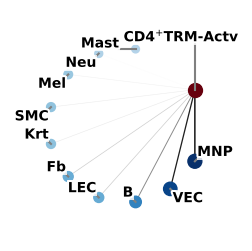

In [42]:
import textalloc as ta

layout_node_order1 = (
    ["blank1"] + rcv_order1.index.to_list() + ["blank2"] + src_order1.index.to_list()
)
pos = nx.circular_layout(layout_node_order1, center=(0, 0))
fig, ax = plt.subplots(figsize=(3, 3))
_pos = dict(zip(layout_node_order1, pos.values()))
pos = {x: _pos[x] for x in node_order1}
nx_plot_params = dict(
    G=G,
    pos=pos,
    ax=ax,
)

cur_nodes1 = [x for x in node_order1 if x in net_df1["source"].unique()]
nx.draw_networkx_nodes(
    nodelist=cur_nodes1,
    node_size=nd[cur_nodes1] * 1e2,
    node_color=nd[cur_nodes1],
    vmin=0.0,
    vmax=1.0,
    cmap=mpl.colormaps["Blues"],
    **nx_plot_params,
)

cur_nodes1 = [x for x in node_order1 if x in net_df1["target"].unique()]
nx.draw_networkx_nodes(
    nodelist=cur_nodes1,
    node_size=nd[cur_nodes1] * 1e2,
    node_color=nd[cur_nodes1],
    vmin=0.0,
    vmax=1.0,
    cmap=mpl.colormaps["Reds"],
    **nx_plot_params,
)

edge_order1 = [
    (x[1], x[2])
    for x in pd.DataFrame([(x[0], x[1], x[-1]["weight"]) for x in G.edges(data=True)])
    .sort_values(2)
    .itertuples()
]
ew1 = [(G.get_edge_data(x[0], x[1])["weight"] / ew_max1) for x in edge_order1]
nx.draw_networkx_edges(
    edgelist=edge_order1,
    width=ew1 * 2,
    arrowstyle="-",
    arrowsize=0,
    node_size=nd * 1e2,
    edge_color=ew1,
    edge_cmap=mpl.colormaps["Greys"],
    **nx_plot_params,
)

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
textloc_params = dict(
    textsize=[plt.rcParams["font.size"]] * len(pos),
    linewidth=plt.rcParams["lines.linewidth"],
    linecolor="gray",
    avoid_label_lines_overlap=True,
    avoid_crossing_label_lines=True,
    min_distance=1e-2,
    max_distance=0.25,
    nbr_candidates=int(1e3),
    va="center",
    ha="center",
    color="black",
    fontweight="bold",
    path_effects=[
        mpl.patheffects.withStroke(
            linewidth=plt.rcParams["lines.linewidth"] * 2, foreground="white"
        )
    ],
    bbox=dict(
        alpha=0.8,
        boxstyle="Square,pad=0.05",
        facecolor="w",
        edgecolor="none",
        lw=0.0,
    ),
)
all_pos = np.array(list(pos.values()))
xl = []
yl = []
for _, row in net_df1.iterrows():
    pos_s = pos[row["source"]]
    pos_r = pos[row["target"]]
    xl.append([pos_s[0], pos_r[0]])
    yl.append([pos_s[1], pos_r[1]])
ta.allocate(
    ax=ax,
    x=all_pos[:, 0],
    y=all_pos[:, 1],
    text_list=list(pos.keys()),
    x_lines=xl,
    y_lines=yl,
    **textloc_params,
)

ax.grid(False)
ax.set_axis_off()

In [43]:
cd8 = res1[~res1['target'].str.startswith("PV:CD4")]
cd8

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_gmeans,gmean_pvals
526,CLEC2B,CLEC2B,1.243494,0.803442,KLRB1,KLRB1,1.498576,0.711890,PV:VEC,PV:CD8$^{+}$TRM-Actv,1.365090,0.000
322,CLEC2B,CLEC2B,1.216102,0.723883,KLRB1,KLRB1,1.498576,0.711890,PV:Fb,PV:CD8$^{+}$TRM-Actv,1.349971,0.000
369,CLEC2B,CLEC2B,1.122512,0.637887,KLRB1,KLRB1,1.498576,0.711890,PV:LEC,PV:CD8$^{+}$TRM-Actv,1.296985,0.000
441,HLA-E,HLA-E,2.398609,0.940845,CD8A,CD8A,0.693661,0.476372,PV:Mel,PV:CD8$^{+}$TRM-Actv,1.289892,0.000
512,HLA-E,HLA-E,2.368953,0.954031,CD8A,CD8A,0.693661,0.476372,PV:VEC,PV:CD8$^{+}$TRM-Actv,1.281894,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
277,IL23A,IL23A,0.079042,0.076923,IL12RB2,IL12RB2,0.076050,0.070884,PV:B,PV:CD8$^{+}$TRM-Actv,0.077532,0.002
448,CCN1,CCN1,0.069165,0.064789,ITGAV,ITGAV,0.083830,0.084604,PV:Mel,PV:CD8$^{+}$TRM-Actv,0.076145,1.000
477,CCN2,CCN2,0.067625,0.054726,MAPK3,MAPK3,0.063315,0.068598,PV:Neu,PV:CD8$^{+}$TRM-Actv,0.065435,1.000
534,HLA-DMB,HLA-DMB,0.050560,0.058424,CTSL,CTSL,0.067762,0.067073,PV:VEC,PV:CD8$^{+}$TRM-Actv,0.058532,1.000


In [44]:
df2 = (
    cd8.loc[(cd8["gmean_pvals"] < 1e-2), ["source", "target", "lr_gmeans"]]
    .groupby(["source", "target"])
    .sum()
    .reset_index()
)
df2["sender"] = df2["source"].map(lambda x: str(x).split(":")[-1]).astype("category")
df2["receiver"] = df2["target"].map(lambda x: str(x).split(":")[-1]).astype("category")
# df2["condition"] = df2["cluster_1"].map(lambda x: str(x).split(":")[0]).astype("category")
net_df2 = df2[["sender", "receiver", "lr_gmeans"]]
net_df2.columns = ["source", "target", "weight"]
net_df2 = net_df2.loc[net_df2["weight"] > 0]
net_df2 = net_df2.sort_values("weight")
G = nx.from_pandas_edgelist(net_df2, create_using=nx.DiGraph, edge_attr="weight")
print(G)

nd = pd.Series(dict(G.degree(weight="weight")))
rcvs = net_df2["target"].unique()
r_max = nd.loc[nd.index.isin(rcvs)].max()
s_max = nd.loc[~nd.index.isin(rcvs)].max()
nd = pd.Series({ct: w / (r_max if ct in rcvs else s_max) for ct, w in nd.items()})

ew2 = np.array([x[-1]["weight"] for x in G.edges(data=True)])
ew_max2 = ew2.max()

DiGraph with 11 nodes and 10 edges


In [45]:
df2

,source,target,lr_gmeans,sender,receiver
0,PV:B,PV:CD8$^{+}$TRM-Actv,11.467223,B,CD8$^{+}$TRM-Actv
1,PV:Fb,PV:CD8$^{+}$TRM-Actv,9.471302,Fb,CD8$^{+}$TRM-Actv
2,PV:Krt,PV:CD8$^{+}$TRM-Actv,7.173381,Krt,CD8$^{+}$TRM-Actv
3,PV:LEC,PV:CD8$^{+}$TRM-Actv,9.282905,LEC,CD8$^{+}$TRM-Actv
4,PV:MNP,PV:CD8$^{+}$TRM-Actv,17.596724,MNP,CD8$^{+}$TRM-Actv
5,PV:Mast,PV:CD8$^{+}$TRM-Actv,5.636567,Mast,CD8$^{+}$TRM-Actv
6,PV:Mel,PV:CD8$^{+}$TRM-Actv,7.070972,Mel,CD8$^{+}$TRM-Actv
7,PV:Neu,PV:CD8$^{+}$TRM-Actv,6.053727,Neu,CD8$^{+}$TRM-Actv
8,PV:SMC,PV:CD8$^{+}$TRM-Actv,7.987862,SMC,CD8$^{+}$TRM-Actv
9,PV:VEC,PV:CD8$^{+}$TRM-Actv,14.889436,VEC,CD8$^{+}$TRM-Actv


In [46]:
src_order2 = (
    net_df2[["source", "weight"]]
    .groupby("source", observed=True)
    .sum()
    .squeeze()
    .sort_values()
)

rcv_order2 = net_df2[["target", "weight"]].groupby("target", observed=True).sum()
rcv_order2["ct"] = rcv_order2.index.map(lambda x: str(x).split(":")[-1]).astype(
    "category"
)
ct_order2 = (
    rcv_order2[["ct", "weight"]]
    .groupby("ct", observed=True)
    .sum()
    .sort_values("weight")
    .index[::-1]
)
rcv_order2["ct"] = rcv_order2["ct"].cat.reorder_categories(ct_order2, ordered=True)
rcv_order2 = rcv_order2.sort_values(["ct"])

node_order2 = rcv_order2.index.to_list() + src_order2.index.to_list()
node_order2

['CD8$^{+}$TRM-Actv',
 'Mast',
 'Neu',
 'Mel',
 'Krt',
 'SMC',
 'LEC',
 'Fb',
 'B',
 'VEC',
 'MNP']

/tmp/ipykernel_1975938/1408091242.py:45: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
/data/conda-users/envs/qbe2n/pso-sc-gpu-250514/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:792: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/data/conda-users/envs/qbe2n/pso-sc-gpu-250514/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:793: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


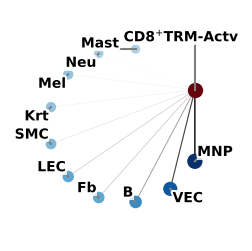

In [51]:
import textalloc as ta

layout_node_order2 = (
    ["blank1"] + rcv_order2.index.to_list() + ["blank2"] + src_order2.index.to_list()
)
pos = nx.circular_layout(layout_node_order2, center=(0, 0))
fig, ax = plt.subplots(figsize=(3, 3))
_pos = dict(zip(layout_node_order2, pos.values()))
pos = {x: _pos[x] for x in node_order2}
nx_plot_params = dict(
    G=G,
    pos=pos,
    ax=ax,
)

cur_nodes2 = [x for x in node_order2 if x in net_df2["source"].unique()]
nx.draw_networkx_nodes(
    nodelist=cur_nodes2,
    node_size=nd[cur_nodes2] * 1e2,
    node_color=nd[cur_nodes2],
    vmin=0.0,
    vmax=1.0,
    cmap=mpl.colormaps["Blues"],
    **nx_plot_params,
)

cur_nodes2 = [x for x in node_order2 if x in net_df2["target"].unique()]
nx.draw_networkx_nodes(
    nodelist=cur_nodes2,
    node_size=nd[cur_nodes2] * 1e2,
    node_color=nd[cur_nodes2],
    vmin=0.0,
    vmax=1.0,
    cmap=mpl.colormaps["Reds"],
    **nx_plot_params,
)

edge_order2 = [
    (x[1], x[2])
    for x in pd.DataFrame([(x[0], x[1], x[-1]["weight"]) for x in G.edges(data=True)])
    .sort_values(2)
    .itertuples()
]
ew1 = [(G.get_edge_data(x[0], x[1])["weight"] / ew_max2) for x in edge_order2]
nx.draw_networkx_edges(
    edgelist=edge_order2,
    width=ew1 * 2,
    arrowstyle="-",
    arrowsize=0,
    node_size=nd * 1e2,
    edge_color=ew1,
    edge_cmap=mpl.colormaps["Greys"],
    **nx_plot_params,
)

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
textloc_params = dict(
    textsize=[plt.rcParams["font.size"]] * len(pos),
    linewidth=plt.rcParams["lines.linewidth"],
    linecolor="gray",
    avoid_label_lines_overlap=True,
    avoid_crossing_label_lines=True,
    min_distance=1e-2,
    max_distance=0.25,
    nbr_candidates=int(1e3),
    va="center",
    ha="center",
    color="black",
    fontweight="bold",
    path_effects=[
        mpl.patheffects.withStroke(
            linewidth=plt.rcParams["lines.linewidth"] * 2, foreground="white"
        )
    ],
    bbox=dict(
        alpha=0.8,
        boxstyle="Square,pad=0.05",
        facecolor="w",
        edgecolor="none",
        lw=0.0,
    ),
)
all_pos = np.array(list(pos.values()))
xl = []
yl = []
for _, row in net_df2.iterrows():
    pos_s = pos[row["source"]]
    pos_r = pos[row["target"]]
    xl.append([pos_s[0], pos_r[0]])
    yl.append([pos_s[1], pos_r[1]])
ta.allocate(
    ax=ax,
    x=all_pos[:, 0],
    y=all_pos[:, 1],
    text_list=list(pos.keys()),
    x_lines=xl,
    y_lines=yl,
    **textloc_params,
)

ax.grid(False)
ax.set_axis_off()